In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


2025-05-10 10:46:59.436090: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746874019.487973    6276 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746874019.502453    6276 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746874019.610494    6276 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746874019.610532    6276 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746874019.610534    6276 computation_placer.cc:177] computation placer alr

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8307606800648640044
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 45748584448
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12469655377632713902
physical_device_desc: "device: 0, name: NVIDIA L40S, pci bus id: 0000:34:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


I0000 00:00:1746874022.704593    6276 gpu_device.cc:2019] Created device /device:GPU:0 with 43629 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:34:00.0, compute capability: 8.9


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


# IMPORTS

In [3]:
import numpy as np
import pandas as pd
import re
import tensorflow as tf
import csv
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle

# LOAD AND CLEAN DATA 

In [4]:
try:
    raw = pd.read_csv(
        "news_summary_more.csv",
        encoding="iso-8859-1",
        engine="python",
        on_bad_lines="skip"
    )
except TypeError:
    raw = pd.read_csv(
        "news_summary_more.csv",
        encoding="iso-8859-1",
        engine="python",
        error_bad_lines=False
    )

print(f"Successfully loaded data with {len(raw)} rows")
print(f"Columns in the raw dataframe: {raw.columns.tolist()}")

Successfully loaded data with 98400 rows
Columns in the raw dataframe: ['a US General dipped bullets in pig\'s blood to fight Islamic militants over a hundred years ago. ""Study what General Pershing of the United States did to terrorists when caught. There was no more Radical Islamic Terror for 35 years!"" Trump tweeted."']


In [5]:
if not {"headlines", "text"}.issubset(raw.columns):
    print("Warning: Expected columns not found. Attempting to split raw data into two fields.")
    if raw.shape[1] == 1:
        # Split the single column on the first comma into 'headlines' and 'text'
        split_df = raw.iloc[:, 0].str.split(pat=",", n=1, expand=True)
    else:
        # If there are at least two columns, just take the first two
        split_df = raw.iloc[:, [0, 1]]
    split_df.columns = ["headlines", "text"]
    raw = split_df

# Build the working dataframe
pre = pd.DataFrame({
    'text': raw['text'],
    'summary': raw['headlines']
})

In [6]:
# Cleaning function
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"\([^)]*\)", "", text)
    text = re.sub('"', "", text)
    text = re.sub(r"'s\b", "", text)
    text = re.sub("[^a-zA-Z]", " ", text)
    text = re.sub(r"[m]{2,}", "mm", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

In [7]:
# Apply cleaning
pre['clean_text'] = pre['text'].apply(clean_text)
pre['clean_summary'] = pre['summary'].apply(clean_text)

# Filter short samples
orig_count = len(pre)
pre = pre[ pre['clean_text'].str.split().str.len() > 30 ]
pre = pre[ pre['clean_summary'].str.split().str.len() > 3 ]
print(f"Filtered from {orig_count} to {len(pre)} rows")

# Add start/end tokens
pre['clean_summary'] = pre['clean_summary'].apply(lambda x: 'sostok ' + x + ' eostok')

Filtered from 98400 to 54884 rows


# TOKENIZATION 

In [8]:
max_text_len = 100
max_summary_len = 15

In [9]:
X = pre['clean_text']
Y = pre['clean_summary']

x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(X)
x_seq = x_tokenizer.texts_to_sequences(X)
x_pad = pad_sequences(x_seq, maxlen=max_text_len, padding='post')

y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(Y)
y_seq = y_tokenizer.texts_to_sequences(Y)
y_pad = pad_sequences(y_seq, maxlen=max_summary_len, padding='post')

x_voc = len(x_tokenizer.word_index) + 1
y_voc = len(y_tokenizer.word_index) + 1
print(f"Text vocab size: {x_voc}")
print(f"Summary vocab size: {y_voc}")

Text vocab size: 54454
Summary vocab size: 34031


In [10]:
reverse_source_word_index = x_tokenizer.index_word
reverse_target_word_index = y_tokenizer.index_word
target_word_index = y_tokenizer.word_index

# Save tokenizers
with open("x_tokenizer.pkl", "wb") as f:
    pickle.dump(x_tokenizer, f)
with open("y_tokenizer.pkl", "wb") as f:
    pickle.dump(y_tokenizer, f)

In [11]:
# Split data
drop_idx = np.random.RandomState(seed=0).permutation(len(x_pad))
train_idx = drop_idx[:int(len(x_pad)*0.9)]
val_idx = drop_idx[int(len(x_pad)*0.9):]
x_tr, y_tr = x_pad[train_idx], y_pad[train_idx]
x_val, y_val = x_pad[val_idx], y_pad[val_idx]
print(f"Train: {len(x_tr)}  Val: {len(x_val)}")

Train: 49395  Val: 5489


# MODEL 

In [12]:
latent_dim, embed_dim = 300, 100
encoder_inputs = Input(shape=(max_text_len,))
enc_emb = Embedding(x_voc, embed_dim, trainable=True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
_, state_h, state_c = encoder_lstm(enc_emb)

decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(y_voc, embed_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)
dec_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
dec_outputs, _, _ = dec_lstm(dec_emb, initial_state=[state_h, state_c])
dec_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
dec_outputs = dec_dense(dec_outputs)

model = Model([encoder_inputs, decoder_inputs], dec_outputs)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
model.summary()

I0000 00:00:1746874030.837759    6276 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43629 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:34:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 100)  │  5,445,400 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 100) │  3,403,100 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 300),     │    481,200 │ embedding[0][0]   │
│                     │ (None, 300),      │            │                   │
│                     │ (None, 300)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, None,     │    481,200 │ embedding_1[0][0… │
│                     │ 300), (None,      │            │ lstm[0][1],       │
│                     │ 300), (None,      │            │ lstm[0][2]        │
│                     │ 300)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, None,      │ 10,243,331 │ lstm_1[0][0]      │
│ (TimeDistributed)   │ 34031)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 20,054,231 (76.50 MB)

 Trainable params: 20,054,231 (76.50 MB)

 Non-trainable params: 0 (0.00 B)

# TRAIN 

In [13]:
early = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
hist = model.fit(
    [x_tr, y_tr[:, :-1]],
    y_tr.reshape(len(y_tr), max_summary_len, 1)[:, 1:],
    epochs=50,
    batch_size=128,
    validation_data=([x_val, y_val[:, :-1]], y_val.reshape(len(y_val), max_summary_len, 1)[:, 1:]),
    callbacks=[early]
)

Epoch 1/50


I0000 00:00:1746874034.551018    6577 cuda_dnn.cc:529] Loaded cuDNN version 90701


386/386 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - loss: 7.1476 - val_loss: 6.0374
Epoch 2/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - loss: 5.9897 - val_loss: 5.8868
Epoch 3/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - loss: 5.8251 - val_loss: 5.7048
Epoch 4/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - loss: 5.6574 - val_loss: 5.5578
Epoch 5/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - loss: 5.4844 - val_loss: 5.4248
Epoch 6/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - loss: 5.3760 - val_loss: 5.3336
Epoch 7/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - loss: 5.2541 - val_loss: 5.2586
Epoch 8/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - loss: 5.1661 - val_loss: 5.3090
Epoch 9/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - loss: 5.0825 - val_loss: 5.1189
Epoch 10/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - loss: 4.9840 - val_loss: 5.0587
Epoch 11/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - loss: 4.9327 - val_loss: 5.0108
Epoch 12/50
386/386 ━━━━━━━━━━━━━━━━━━━━ 

In [14]:
model.save("seq2seq_model.h5")

# PLOT 

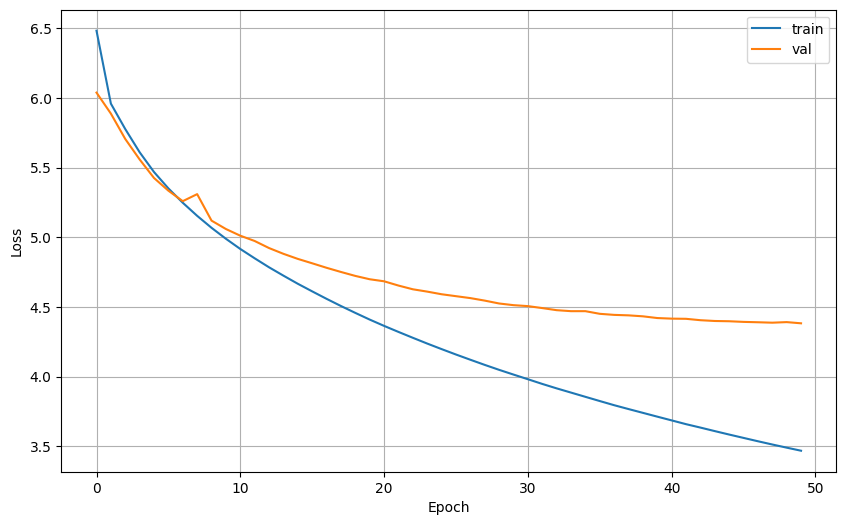

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('training_loss.png')
plt.show()

# INFERENCE 

In [16]:
encoder_model = Model(encoder_inputs, [state_h, state_c])
dec_state_h = Input(shape=(latent_dim,))
dec_state_c = Input(shape=(latent_dim,))
dec_emb2 = dec_emb_layer(decoder_inputs)
dec_out2, dec_h2, dec_c2 = dec_lstm(dec_emb2, initial_state=[dec_state_h, dec_state_c])
dec_out2 = dec_dense(dec_out2)
decoder_model = Model([decoder_inputs, dec_state_h, dec_state_c], [dec_out2, dec_h2, dec_c2])

In [17]:
# Helper functions
def seq2text(seq):
    return ' '.join([reverse_source_word_index.get(i, '') for i in seq if i != 0]).strip()

def seq2summary(seq):
    skip = {0, target_word_index['sostok'], target_word_index['eostok']}
    return ' '.join([reverse_target_word_index.get(i, '') for i in seq if i not in skip]).strip()

def decode_sequence(input_seq):
    h, c = encoder_model.predict(input_seq)
    target = np.array([[target_word_index['sostok']]])
    result = ''
    while True:
        out, h, c = decoder_model.predict([target, h, c])
        idx = np.argmax(out[0, -1, :])
        word = reverse_target_word_index.get(idx, '')
        if word in ('', 'eostok') or len(result.split()) >= max_summary_len-1:
            break
        result += ' ' + word
        target = np.array([[idx]])
    return result.strip()

In [18]:
# SAMPLE
print("\n===== SAMPLE OUTPUTS =====")
for i in range(5):
    txt = seq2text(x_val[i])
    print(f"Text: {txt[:200] + '...' if len(txt) > 200 else txt}")
    print("Original:", seq2summary(y_val[i]))
    print("Predicted:", decode_sequence(x_val[i].reshape(1, max_text_len)))
    print('-'*70)


===== SAMPLE OUTPUTS =====
Text: sacred games writer varun grover has shared the evidence of his innocence in an open letter a junior at bhu accused him of sexually harassing her but kept her identity anonymous he claimed that the pe...
Original: denying sexual harassment allegations against him
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted: the government has said that the government is not a very long
----------------------------------------------------------------------
Text: engineers and busin